In [11]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

In [12]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [13]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3


## Load analysis file

In [15]:
df_box = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
df_box.GetContentFile('analysis_box.csv')  

df_box= pd.read_csv('analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,3.109101,17.874693,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,4.795929,10.082423,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,4.842301,9.965636,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333


In [16]:
df_box.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]
predictors_acs= df_box.columns[df_box.columns.get_loc("totpop"):df_box.columns.get_loc("crowdingrenter") + 1].tolist()
predictors_full= predictors + predictors_acs
predictors_full

['lotarea',
 'bldgarea',
 'numbldgs',
 'numfloors',
 'unitsres',
 'unitstotal',
 'assessland',
 'assesstot',
 'exempttot',
 'yearbuilt',
 'holc_AB',
 'holc_CD',
 'holc_D',
 'tot_hpd_vio',
 'hpd_fire_vio',
 'hpd_b_c_vio',
 'viol_count_per_unit',
 'hpd_fire_vio_per_unit',
 'hpd_b_c_vio_per_unit',
 'AL',
 'NB',
 'average_energy_usage',
 'average_energy_usage_mi',
 'totpop',
 'popdens',
 'areasqmile',
 'males',
 'females',
 'pop18under',
 'pop18_34',
 'pop35_64',
 'pop65plus',
 'pophispanic',
 'popnhwhite',
 'popnhblack',
 'popnhaian',
 'popnhasian',
 'popnhhawainpi',
 'popnhother',
 'popnhtwoplus',
 'housing',
 'housingoccupied',
 'renterhousing',
 'oc_halfless',
 'oc_half_1',
 'oc_1_onehalf',
 'oc_onehalf_2',
 'oc_2plus',
 'roc_halfless',
 'roc_half_1',
 'roc_1_onehalf',
 'roc_onehalf_2',
 'roc_2plus',
 'medianyearbuilt',
 'mediangrossrent',
 'medianhhincome',
 'gini',
 'year',
 'pct18under',
 'pct18_34',
 'pct35_64',
 'pct65plus',
 'pcthispanic',
 'pctnhwhite',
 'pctnhblack',
 'pctnhaia

In [17]:
outcomes= ["dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"]
df_box[outcomes].head()

,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,32.666667,6,1.200000
1,42.333333,3,3.000000
2,36.880000,25,1.923077
3,15.600000,5,1.666667
4,32.181818,44,2.933333


# Decision Trees and Random Forest Models

In [18]:
df_box.describe()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357528e+04,2.571084e+04,1.933244,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.617813,...,1.993614,45.607389,54.392611,8.104744,9.827415,2.696305,1.891626,40.335653,27.951859,2.381331
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.845988,...,1.846193,26.055808,26.055808,6.618311,8.148408,1.179745,0.752555,18.500212,48.572309,2.800509
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226120e+03,1925.107672,...,0.660968,23.841841,30.651477,3.421687,3.740358,2.090909,1.571429,32.290179,5.000000,1.200000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,1.555701,44.368239,55.631761,6.309751,8.125000,2.909091,2.000000,40.333333,13.000000,1.666667
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,2.786200,69.348523,76.158159,10.875723,13.930348,3.312500,2.250000,49.910985,31.000000,2.538462
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,12.851406,100.000000,100.000000,53.578192,55.087359,23.928571,13.500000,450.000000,1288.000000,80.500000


In [46]:
df_box.loc[df_box["avg_fire_ev_yr"]==0].shape[0]/df_box.shape[0]

0.0625920471281296

In [20]:
# assert no missingness
assert (df_box.isna().sum(axis = 0).sum() == 0)

In [24]:
df_box_clean= df_box.dropna(how = "any")
df_box_clean.shape

(10864, 80)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X = df_box_clean.loc[:, predictors_full]
y = df_box_clean.loc[X.index, outcomes[2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

dt1 = DecisionTreeRegressor(max_depth=10)
dt1.fit(X_train, y_train)

dt2 = DecisionTreeRegressor(max_depth=15)
dt2.fit(X_train, y_train)

y_pred1= dt1.predict(X_test)
y_pred2= dt2.predict(X_test)

print("R2 for model 1:", dt1.score(X_test, y_test))
print("R2 for model 2:", dt2.score(X_test, y_test))

R2 for model 1: -0.36226951831022824
R2 for model 2: -0.6751307626180143


## Tuning

In [55]:
from sklearn.model_selection import GridSearchCV
# use max_depth to control the complexity of the tre
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeRegressor()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train,y_train)
print(rs.best_params_)
print(rs.score(X_test, y_test))

{'max_depth': 4}
0.09116678617778162


In [57]:
# the R2 is pretty low...

## Feature Importance

In [59]:
dt = DecisionTreeRegressor(max_depth=rs.best_params_['max_depth'])
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 5 most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]

,variables,importance
15,hpd_b_c_vio,0.473528
24,popdens,0.201219
34,popnhblack,0.093201
25,areasqmile,0.082885
65,pctnhaian,0.050868
55,medianhhincome,0.049081
0,lotarea,0.021646
64,pctnhblack,0.019536
70,pctownerocch,0.008036
48,roc_halfless,0.0


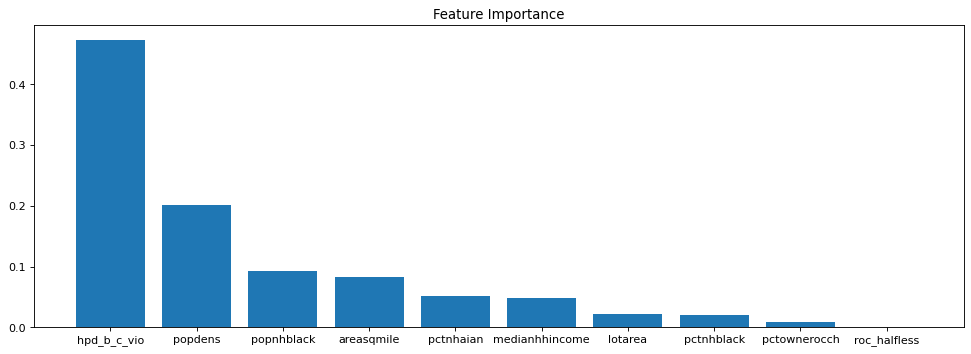

In [71]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,0],
        Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,1])
plt.title("Feature Importance");

## Random Forests

In [80]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=30, n_jobs=-1,max_depth = 4)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
print("R2 with random forest:", rf.score(X_test, y_test))

R2 with random forest: 0.20644798085587768


In [79]:
param_grid = {'max_depth':range(1,30)}
rf = RandomForestRegressor(n_jobs=-1, n_estimators = 30)
gs = GridSearchCV(rf,param_grid=param_grid)
rs = gs.fit(X_train,y_train)
y_pred= rs.predict(X_test)

print(rs.best_params_)
print("R2 with best paramters:", rs.score(X_test, y_test))

{'max_depth': 9}
R2 with best paramters: 0.18856937919581918
